# Selection of Best Model on internal validation set

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve


In [48]:
data = pd.read_csv("ensemble/model_probabilities_non_calibrated.csv")
# Add a hypothetical model with random probabilities between 0.51 and 0.99
data['random_model_positive'] = np.random.uniform(0.50, 0.99, len(data))
# Add a hypothetical model with random probabilities between 0.1 and 0.49
data['random_model_negative'] = np.random.uniform(0.01, 0.49, len(data))

In [51]:
# Extract true labels
y_true = data['true_labels']

# Extract model probabilities
model_probs = data.drop(columns=['true_labels'])

# Initialize a dictionary to store decision curve data
decision_curve_data = {}

# Calculate ROC curve for each model
for model in model_probs.columns:
    fpr, tpr, thresholds = roc_curve(y_true, model_probs[model])
    decision_curve_data[model] = {'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds}

# Adjust the thresholds for the all_positive model
for model in decision_curve_data:
    # if (model == 'random_model_positive') or (model == 'random_model_negative'):
    decision_curve_data[model]['thresholds'] = np.where(decision_curve_data[model]['thresholds'] == np.inf, 1, decision_curve_data[model]['thresholds'])

decision_curve_data

{'xgb_non_calibrated_proba': {'fpr': array([0.        , 0.        , 0.        , 0.03571429, 0.03571429,
         0.07142857, 0.07142857, 0.10714286, 0.10714286, 0.17857143,
         0.17857143, 0.25      , 0.25      , 0.28571429, 0.28571429,
         0.35714286, 0.35714286, 0.42857143, 0.42857143, 0.5       ,
         0.5       , 0.53571429, 0.53571429, 0.64285714, 0.64285714,
         1.        ]),
  'tpr': array([0.        , 0.05263158, 0.15789474, 0.15789474, 0.36842105,
         0.36842105, 0.47368421, 0.47368421, 0.52631579, 0.52631579,
         0.57894737, 0.57894737, 0.63157895, 0.63157895, 0.68421053,
         0.68421053, 0.73684211, 0.73684211, 0.78947368, 0.78947368,
         0.89473684, 0.89473684, 0.94736842, 0.94736842, 1.        ,
         1.        ]),
  'thresholds': array([1.        , 0.859476  , 0.848595  , 0.81590205, 0.7508974 ,
         0.70718884, 0.68441886, 0.66864187, 0.65450984, 0.57469285,
         0.5724391 , 0.5494892 , 0.5425521 , 0.54091007, 0.5010148 ,
 

In [52]:
def calculate_net_benefit(fpr, tpr, thresholds, prevalence):
    """
    Calculate the net benefit for given FPR, TPR, and thresholds.
    """
    net_benefits = []
    N = len(fpr)
    
    for p, tp, fp in zip(thresholds, tpr, fpr):
        if p == 1:
            net_benefit = np.nan  # Avoid division by zero
        else:
            net_benefit = (tp * prevalence) - (fp * (1 - prevalence) * p / (1 - p))
        net_benefits.append(net_benefit)
        
    return net_benefits



In [55]:
result_df.columns

Index(['true_labels', 'xgb_non_calibrated_proba', 'cb_non_calibrated_proba',
       'lgbm_non_calibrated_proba', 'gb_non_calibrated_proba',
       'rf_non_calibrated_proba', 'nb_non_calibrated_proba',
       'svm_non_calibrated_proba', 'knn_non_calibrated_proba',
       'lr_non_calibrated_proba'],
      dtype='object')

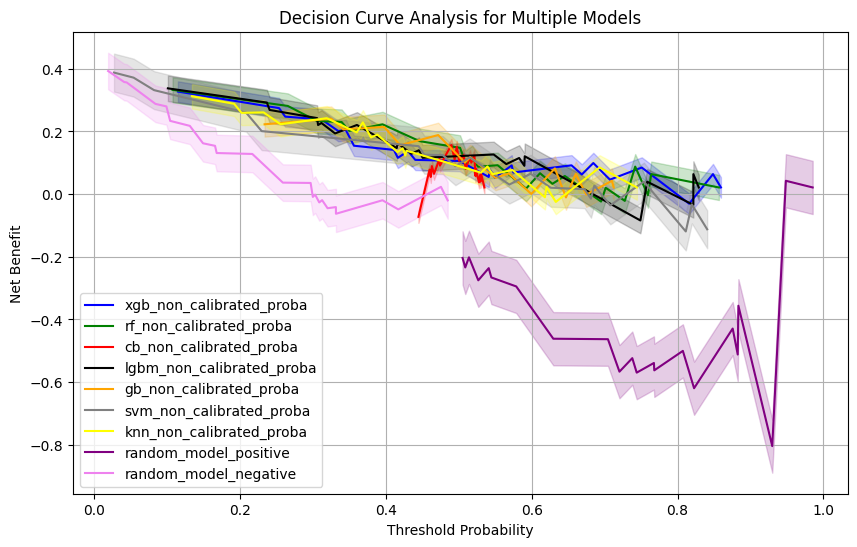

In [70]:
# Models to plot
models = ['xgb_non_calibrated_proba', 'rf_non_calibrated_proba', 
          'cb_non_calibrated_proba','lgbm_non_calibrated_proba',
          'gb_non_calibrated_proba','svm_non_calibrated_proba','knn_non_calibrated_proba',
          'random_model_positive', 'random_model_negative']
colors = ['blue', 'green', 'red', 'black', 'orange', 'grey', 'yellow', 'purple', 'violet']

plt.figure(figsize=(10, 6))

# Plot each model with its respective color
for model, color in zip(models, colors):
    net_benefits = decision_curve_data[model]['net_benefit']
    valid_thresholds = decision_curve_data[model]['thresholds'][~np.isnan(net_benefits)]
    valid_net_benefits = np.array(net_benefits)[~np.isnan(net_benefits)]
    
    plt.plot(valid_thresholds, valid_net_benefits, label=model, color=color)
    
    # Calculate and plot 95% CI
    ci = calculate_confidence_interval(valid_net_benefits)
    plt.fill_between(valid_thresholds, valid_net_benefits - ci, valid_net_benefits + ci, color=color, alpha=0.2)

# Plot configuration
plt.xlabel('Threshold Probability')
plt.ylabel('Net Benefit')
plt.title('Decision Curve Analysis for Multiple Models')
plt.legend()
plt.grid(True)
plt.show()

In [64]:
data.columns

Index(['true_labels', 'xgb_non_calibrated_proba', 'cb_non_calibrated_proba',
       'lgbm_non_calibrated_proba', 'gb_non_calibrated_proba',
       'rf_non_calibrated_proba', 'nb_non_calibrated_proba',
       'svm_non_calibrated_proba', 'knn_non_calibrated_proba',
       'lr_non_calibrated_proba', 'random_model_positive',
       'random_model_negative'],
      dtype='object')